In [1]:
# Micrograd is library
# https://github.com/karpathy/micrograd

In [3]:
# Let's create the micrograd

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
class Value:
    
    def __init__(self, data):
        self.data = data
        
    def __repr__(self):
        return f"Value(data = {self.data})"

In [6]:
# creating a object
a = Value(2.0)
a

Value(data = 2.0)

In [7]:
b = Value(-3.0)
b

Value(data = -3.0)

In [8]:
# apparently the python does not know, how to add two Value objects
a + b

TypeError: unsupported operand type(s) for +: 'Value' and 'Value'

#### Python __add__() and  __mul() are functions as one of the magic methods in Python that returns a new object(third) i.e. the addition and multiplication of the other two objects. It implements the addition operator “+” and "*" in Python

In [112]:
class Value:
    
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0         # initial value
        
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    # Note:
    #out = Class(argument, (who are childrem node, again children node), 'name of operation')
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self,other), '+')
        return out
    def __sub__(self, other):
        out = Value(self.data - other.data, (self, other), '-')
        return out
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    def __truediv__(self, other):
        out = Value(self.data / other.data,  (self, other), '/')
        return out
    def tanh(self):
        x = self.data
        t = (np.exp(x) - np.exp(-x))/ (np.exp(x) + np.exp(-x))
        out = Value(t, (self, ), 'tanh')
        return out

In [106]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b ; e.label = 'e'
f = Value(-2.0, label = 'f')
d = e + c ; d.label = 'd'
L = d * f ; L.label = 'L' 

print(a+b)
print(a*b)
print(a/b)

# for mutiple value objects, we will need to add the _children varibale.
print(L)

Value(data = -1.0)
Value(data = -6.0)
Value(data = -0.6666666666666666)
Value(data = -8.0)


In [11]:
# 'a*b' and 'c' values are the children for creation of "d"
d._prev

{Value(data = -6.0), Value(data = 10.0)}

In [12]:
# "d" was produced by addition of children variables
d._op

'+'

### To visualize, whats going on

In [13]:
# building the graph in "graphviz API"

In [14]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'})   # LR = Left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" %(n.label ,n.data, n.grad ), shape = 'record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:   
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

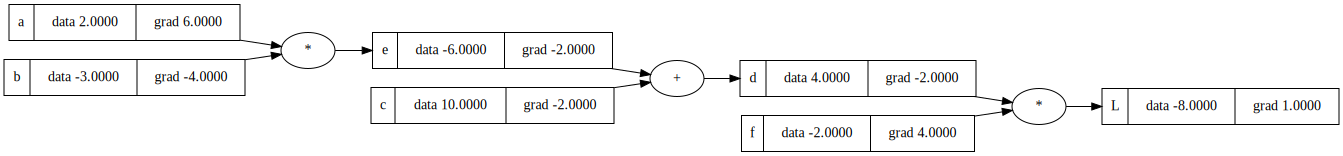

In [64]:
draw_dot(L)

In [16]:
# L = d * f

# dL/dd = f, also dL/df = d 
# lets set then gradients manually

f.grad = 4.0   # value of d
d.grad = -2.0   # value of f

In [ ]:
# L = [e + c]*f
# L = [(a*b)+c]*f
# L = a*b*f + c*f
# therefore, dL/dc = f; dL/de = f;
# dL/da = b*f

In [17]:
L.grad = 1

In [62]:
def  lol():
    
    h = 0.0001
    
    # copying here for these to remain local in the function
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b ; e.label = 'e'
    f = Value(-2.0, label = 'f')
    d = e + c ; d.label = 'd'
    L = d * f ; L.label = 'L' 
    L1 = L.data
    
    # bumping the a variable by h, then trying to approaximate the derivative
    a = Value(2.0 , label = 'a')
    #a.data += h
    b = Value(-3.0, label = 'b')
    #b.data += h 
    c = Value(10.0 , label = 'c')
    #c.data += h
    e = (a*b)  ; e.label = 'e'
    #e.data += h
    f = Value(-2.0, label = 'f')
    f.data += h
    d = e + c ; d.label = 'd'
    # d.data += h
    L = d * f ; L.label = 'L' 
    L2 = L.data
    
    # derivative
    return (L2 - L1)/h

In [67]:
#a.grad = lol()
#b.grad = lol()
#c.grad = lol()
#d.grad = lol()
#e.grad = lol()
f.grad = lol()

## So backpropogation, 
is basically used to calculate the derivative of every children node wrt the output node, once all the derivatives are recorded in the form of gradient, we can use these to find the next output value, for the bump in every node value in direction of gradient all together. 

#### One step optimization, that will consider a step value bump in the direction of gradient
Like gradient descent algo

In [66]:
h = 0.01
a.data += h * a.grad
b.data += h * b.grad
c.data += h * c.grad
d.data += h * d.grad
e.data += h * e.grad
f.data += h * f.grad

# new L.data
e = a*b
d = e+c
L = d*f
print(L)

Value(data = -6.586367999996973)


In [68]:
## Lets take a example of node development with activation  function

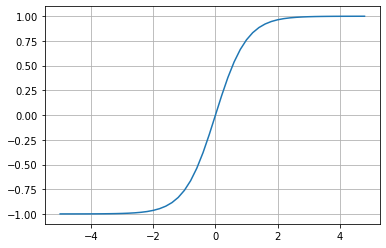

In [71]:
# tanh as the activation function
plt.plot(np.arange(-5.0, 5.0,0.2), np.tanh(np.arange(-5.0, 5.0, 0.2)))
plt.grid()
# this is kind of sigmoid function

In [125]:
# Input nodes
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights
w1 = Value(-3.0, label ='w1')
w2 = Value(1.0, label = 'w2')
# bias
b = Value(6.881847283479823, label = 'b')

# forward propogation of input nodes
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'

#Since we have not tanh function in the class, we can not directly implement it,so go back and define it in class 
# done
o = n.tanh(); o.label = 'o'

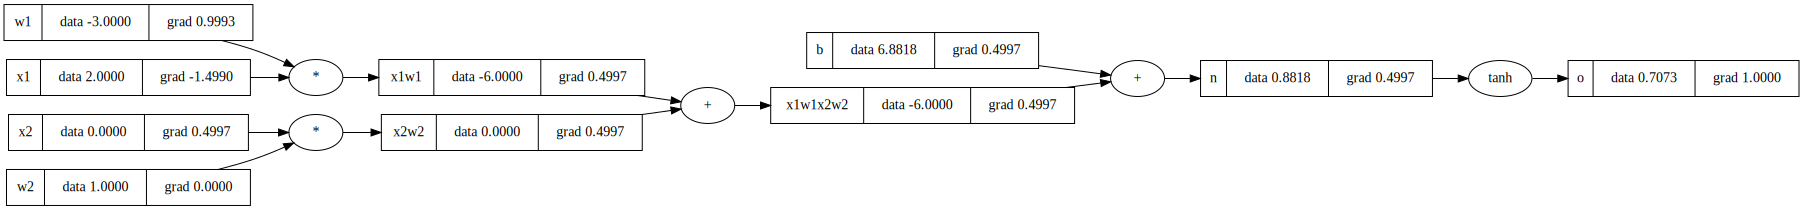

In [136]:
draw_dot(o)

In [127]:
o.grad = 1.0

In [128]:
# o = tanh(n)
# do/dn = 1 - (tanh(n))**2
n.grad = 1 - o.data**2

In [131]:
# do/db = (do/dn) * (dn/db)
# since, dn/db = 1 , check for yourself
# therefore do/db = do/dn
# similarly, do/dx1w1x2w2 = do/dn
b.grad = n.grad
x1w1x2w2.grad = n.grad

In [133]:
# do/dx1w1  =  (do/dx1w1x2w2)*(dx1w1x2w2/dx1w1)
# and dx1w1x2w2/dx1w1 = 1
# therefore do/dx1w1  =  (do/dx1w1x2w2)
# similarly for do/dx2w2  =  (do/dx1w1x2w2)
x1w1.grad  = x1w1x2w2.grad
x2w2.grad  = x1w1x2w2.grad

In [135]:
# do/dw1 = (do/dx1w1) * (dx1w1/ dw1)
# since, dx1w1/dw1 = x1
# do/dw1 = (do/dx1w1) * x1
# similarly:
# do/dx1 = (do/dx1w1) * w1
# do/dw2 = (do/dx2w2) * x2
# do/dx2 = (do/dx2w2) * w2

w1.grad = x1w1.grad * x1.data
x1.grad = x1w1.grad * w1.data
w2.grad = x2w2.grad * x2.data
x2.grad = x2w2.grad * w2.data